In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import jieba

In [2]:
# 读取Excel文件
file_path = './dataset_excel/datasets_text_and_tag.xlsx'  # 请替换为实际的文件路径
data = pd.read_excel(file_path)

data

,Unnamed: 0,text,Authority Bias,Survivorship Bias,Negativity Bias,Zero-Risk Bias,Hyperbolic Discounting,Identifiable Victim Effect,Appeal to Novelty,Urgency Effect,Curiosity,Conformity
0,0,1. 振作起来，你的小维度麻烦很快就会结束！成为一个没有女人能抗拒的情人！http://wh...,0,0,1,0,0,0,0,0,1,0
1,1,6. 我们有假冒的瑞士男士和女士手表，从劳力士到Popular Panerai手表更多信息请...,0,0,0,0,0,0,0,0,1,1
2,2,9. 不要合并您的债务 消除它！合法消除您的信用卡和其他无担保债务 * 无需向您的债权人...,0,0,1,0,0,0,0,0,1,0
3,3,10. Adobe Creative Suite 3 Master Collection f...,1,0,0,0,0,0,0,0,1,0
4,4,13. expresssherbals http://pacelike.com第一个月，您会...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
478,478,"1200. 亲爱的何塞，我正在就帕特森供应账户一事进行接触。截至今天，该账户逾期32,882...",1,0,1,0,0,0,0,0,1,0
479,479,1210. 你好，希望您免受Covid 19的侵害。 我们目前已恢复工作，我们的公司希望在...,0,0,0,0,0,0,0,1,1,1
480,480,1235. 当我们试图交付时，我们想念你..由于信息缺失，我们无法递送您的包裹1550488...,1,0,1,0,0,0,0,1,0,1
481,481,1238. 我们的编号：-4C9X0UE3X34您的编号：4774563677CIBC帝国商...,1,0,0,0,1,0,0,1,0,1


### 数据分析与展示

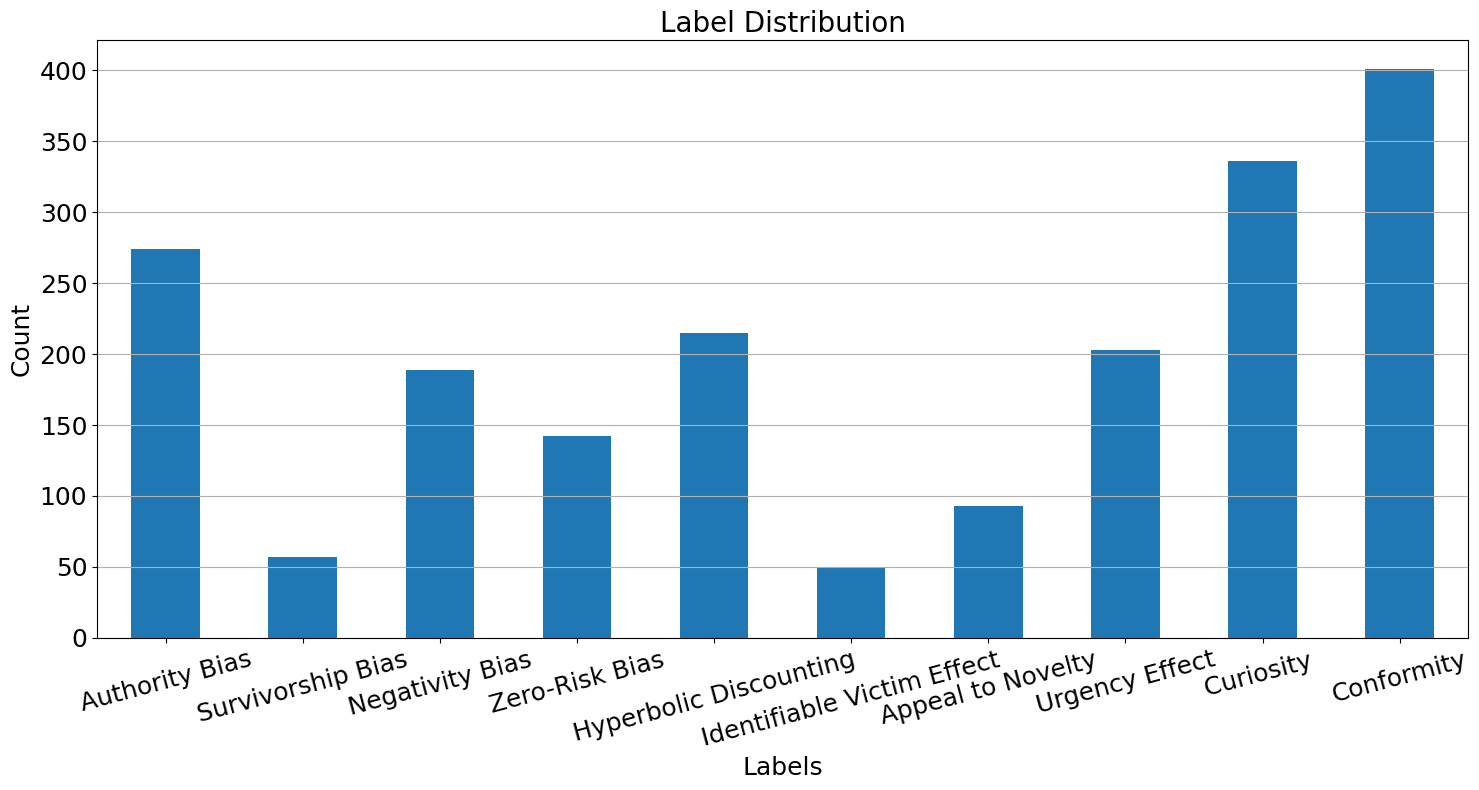

In [9]:
# 假设第二列为文本，后续列为标签
texts = data.iloc[:, 1]
labels = data.iloc[:, 2:]

# 1. 类别分布
plt.figure(figsize=(15, 8))
labels.sum(axis=0).plot(kind='bar')
plt.title('Label Distribution', fontsize=20)  # 设置标题字体大小
plt.xlabel('Labels', fontsize=18)  # 设置x轴标签字体大小
plt.ylabel('Count', fontsize=18)  # 设置y轴标签字体大小
plt.xticks(rotation=15, fontsize=18)  # 设置y轴标签的旋转角度和字体大小
plt.yticks(fontsize=18)  # 设置y轴刻度字体大小
plt.grid(axis='y')  # 添加y轴网格
plt.tight_layout()  # 自动调整布局以适应标题和标签
plt.show()

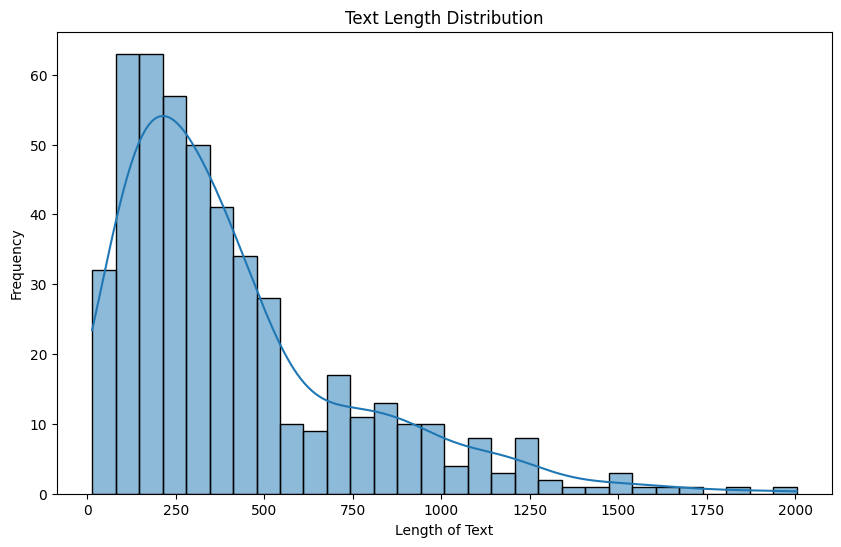

In [4]:
# 2. 文本长度分布
text_lengths = texts.apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

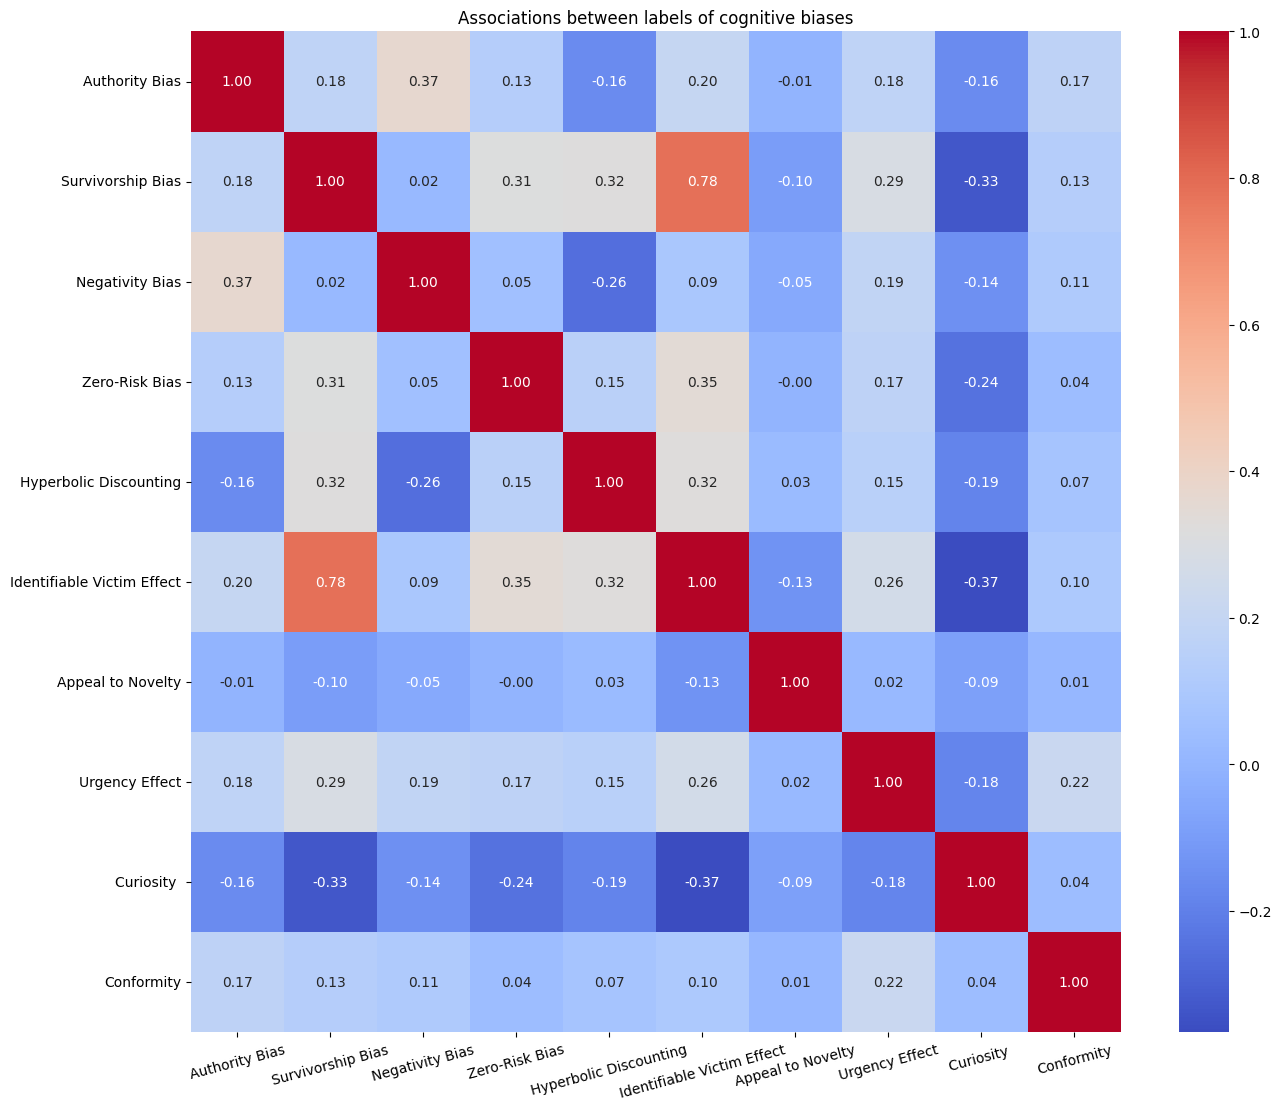

In [10]:
plt.figure(figsize=(15, 13))
sns.heatmap(labels.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 12})  # 增加注释字体大小
plt.title('Associations between labels of cognitive biases', fontsize=18)  # 增加标题字体大小
plt.xticks(rotation=15, fontsize=14)  # 设置x轴标签的旋转角度和字体大小
plt.yticks(fontsize=14)  # 设置y轴标签字体大小
plt.show()

### 处理不均衡问题

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

# 假设第二列为文本数据，后续列为标签
texts = data.iloc[:, 1].astype(str)  # 转换为字符串
labels = data.iloc[:, 2:]

# 文本预处理：分词（中文分词 + 英文以空格分词）
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用jieba进行中文分词
    return ' '.join(words)

# 对所有文本进行预处理
texts = texts.apply(preprocess_text)

# 使用TF-IDF将文本转换为特征向量
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# 遍历每一列标签
results = []
for column in labels.columns:
    y = labels[column].values

    # 使用SMOTE进行过采样
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # 重新划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # 训练和评估模型
    model = OneVsRestClassifier(MultinomialNB())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Results for column {column}:")
    print(f"Accuracy: {accuracy}")
    print(report)
    print("="*50)

### 使用TF-IDF特征提取+SMOTE过采样+不同机器学习方法二分类测试，包括无监督学习

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import jieba
import pandas as pd
import numpy as np

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 文本预处理：分词（中文分词 + 英文以空格分词）
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用jieba进行中文分词
    return ' '.join(words)

# 定义评估模型的函数
def evaluate_model(data, model, unsupervised=False):
    # 第二列为文本数据
    texts = data.iloc[:, 1].astype(str)  # 转换为字符串

    # 对所有文本进行预处理
    texts = texts.apply(preprocess_text)

    # 使用TF-IDF将文本转换为特征向量
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)

    if unsupervised:
        # 无监督学习
        if hasattr(model, 'fit_predict'):
            predicted_labels = model.fit_predict(X.toarray())  # 使用 fit_predict 生成聚类标签
        else:
            model.fit(X.toarray())
            predicted_labels = model.predict(X.toarray())

        # 获取真实标签
        true_labels = data.iloc[:, 2].values  # 假设真实标签在第三列

        # 计算 NMI 和 ARI
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        return {
            "NMI": f"{nmi:.2f}",
            "ARI": f"{ari:.2f}"
        }
    else:
        # 有监督学习
        labels = data.iloc[:, 2:]  # 真实标签

        results = {}
        for column in labels.columns:
            y = labels[column].values

            # 使用SMOTE进行过采样
            smote = SMOTE(random_state=RANDOM_SEED)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # 重新划分训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

            # 使用传入的模型进行训练和评估
            classifier = OneVsRestClassifier(model)
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            results[column] = f"{accuracy * 100:.2f}%"  # 转换为百分比并保留两位小数

        average_accuracy = sum(float(acc[:-1]) for acc in results.values()) / len(results)  # 计算平均准确率
        return results, f"{average_accuracy:.2f}%"  # 保留两位小数


# 存储不同模型的结果
model_results = []

# 定义要测试的模型
models = {
    # 'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    # 'KMeans': KMeans(n_clusters=2, random_state=RANDOM_SEED),
    # 'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
    # 'GaussianMixture': GaussianMixture(n_components=2, random_state=RANDOM_SEED),
}

# 评估每个模型并存储结果
for model_name, model in models.items():
    if model_name in ['KMeans', 'AgglomerativeClustering', 'GaussianMixture']:
        scores = evaluate_model(data, model, unsupervised=True)
        model_results.append({
            'Model': model_name,
            'NMI': scores["NMI"],
            'ARI': scores["ARI"]
        })
    else:
        accuracies, avg_accuracy = evaluate_model(data, model)
        model_results.append({
            'Model': model_name,
            **accuracies,  # 展开每个标签的准确率
            'Average Accuracy': avg_accuracy
        })

# 创建结果的DataFrame
df_results = pd.DataFrame(model_results)

# 显示结果
df_results

### SMOTE + TF-IDF + CNN

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import pandas as pd
import numpy as np

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 文本预处理：分词（中文分词 + 英文以空格分词）
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用jieba进行中文分词
    return ' '.join(words)

# 定义一个自定义的数据集类
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 定义包含L1和L2正则化的CNN模型
class RegularizedCNNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(RegularizedCNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.8)  # 增加Dropout概率

        # 1x1卷积层，用于调整通道数以匹配残差连接
        self.residual_conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1)

        # 计算经过卷积层和池化层后的特征图大小
        self.fc1 = nn.Linear(16640, 32)  # 减少全连接层的神经元数量
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)  # 二分类

    def forward(self, x):
        # 第一个卷积块
        residual = x  # 保存输入以用于残差连接
        x = x.unsqueeze(1)  # 添加一个通道维度
        x = torch.relu(self.bn1(self.conv1(x)))

        # 第二个卷积块
        x = torch.relu(self.bn2(self.conv2(x)))

        # 残差连接（shortcut）
        residual = self.residual_conv(residual.unsqueeze(1))  # 调整维度以匹配卷积块输出
        x = x + residual  # 残差连接：将残差加到当前输出上

        x = self.pool(x)
        x = self.dropout(x)

        # 全连接层
        x = x.view(x.size(0), -1)  # 展平为全连接层的输入
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 定义L1和L2正则化损失函数
def l1_l2_regularization(model, l1_weight, l2_weight):
    l1_loss = 0.0
    l2_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
        l2_loss += torch.sum(torch.square(param))
    return l1_weight * l1_loss + l2_weight * l2_loss

# 定义评估模型的函数
def evaluate_model(data, model, l1_weight=1e-5, l2_weight=1e-4):
    # 第二列为文本数据
    texts = data.iloc[:, 1].astype(str)  # 转换为字符串

    # 对所有文本进行预处理
    texts = texts.apply(preprocess_text)

    # 使用TF-IDF将文本转换为特征向量
    # vectorizer = TfidfVectorizer()
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 3),       # 使用bigrams
        min_df=5,                 # 过滤掉出现频率少于5的词
        max_df=0.8,               # 过滤掉出现在80%以上文档中的词
        sublinear_tf=True,        # 子线性TF缩放
        norm='l2'                 # L2归一化
    )
    X = vectorizer.fit_transform(texts).toarray()
    # 有监督学习
    labels = data.iloc[:, 2:]  # 真实标签

    results = {}
    for column in labels.columns:
        y = labels[column].values

        # 进行特征选择，选择最重要的5000个特征
        selector = SelectKBest(chi2, k=5000)
        X = selector.fit_transform(X, y)

        # 使用SMOTE进行过采样
        smote = SMOTE(random_state=RANDOM_SEED)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        # 重新划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_SEED)

        # 创建数据集和数据加载器
        train_dataset = TextDataset(X_train, y_train)
        test_dataset = TextDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # 构建并训练CNN模型
        input_dim = X_train.shape[1]
        cnn_model = RegularizedCNNClassifier(input_dim=input_dim).to(device)  # 移动模型到GPU
        criterion = nn.CrossEntropyLoss().to(device)  # 移动损失函数到GPU
        optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)  # 加入L2正则化

        best_test_accuracy = 0.0  # 初始化最佳测试集准确率

        # 训练模型并打印每一轮的准确率和损失
        cnn_model.train()
        for epoch in range(200):  # 增加训练轮数
            epoch_loss = 0
            correct_predictions = 0
            total_predictions = 0

            # 训练阶段
            cnn_model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 移动数据到GPU
                optimizer.zero_grad()
                outputs = cnn_model(X_batch)
                loss = criterion(outputs, y_batch)

                # 添加L1和L2正则化
                reg_loss = l1_l2_regularization(cnn_model, l1_weight, l2_weight)
                loss += reg_loss

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)

            train_accuracy = correct_predictions / total_predictions
            epoch_loss /= len(train_loader)

            # 测试阶段
            cnn_model.eval()
            test_preds = []
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # 移动数据到GPU
                    outputs = cnn_model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    test_preds.extend(predicted.cpu().numpy())

            test_accuracy = accuracy_score(y_test, test_preds)
            best_test_accuracy = max(best_test_accuracy, test_accuracy)  # 保留最高的测试集准确率
        print(column, best_test_accuracy)
        results[column] = f"{best_test_accuracy * 100:.2f}%"  # 转换为百分比并保留两位小数

    average_accuracy = sum(float(acc[:-1]) for acc in results.values()) / len(results)
    return results, f"{average_accuracy:.2f}%"

# 假设数据已经加载为data DataFrame
# 评估CNN模型
accuracies, avg_accuracy = evaluate_model(data, model=None)

# 打印结果
print("各标签的准确率:", accuracies)
print("平均准确率:", avg_accuracy)

Using device: cuda


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Authority Bias 0.8818181818181818


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Survivorship Bias 0.9941520467836257


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Pessimism Bias 0.9067796610169492


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Zero-Risk Bias 0.9124087591240876


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Hyperbolic Discounting 0.8796296296296297


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Identifiable Victim Effect 1.0


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Appeal to Novelty 0.9615384615384616


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Urgency Effect 0.8839285714285714


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Curiosity  0.9111111111111111


/data/yyl/conda_envs/pytorch/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5000 is greater than n_features=2080. All the features will be returned.
  warnings.warn(


Conformity 0.9813664596273292
各标签的准确率: {'Authority Bias': '88.18%', 'Survivorship Bias': '99.42%', 'Pessimism Bias': '90.68%', 'Zero-Risk Bias': '91.24%', 'Hyperbolic Discounting': '87.96%', 'Identifiable Victim Effect': '100.00%', 'Appeal to Novelty': '96.15%', 'Urgency Effect': '88.39%', 'Curiosity ': '91.11%', 'Conformity': '98.14%'}
平均准确率: 93.13%


### SMOTE过采样 + RoBERT特征提取 + 机器学习监督学习方案

In [ ]:
import os
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import torch

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 设置模型缓存路径
os.environ['TRANSFORMERS_CACHE'] = '/data/yyl/transformers_cache'

# 加载RoBERTa模型和tokenizer
model_path = '/data/yyl/transformers_cache/roberta-base'  # 替换为你手动下载的模型路径
tokenizer = RobertaTokenizer.from_pretrained(model_path)
roberta_model = RobertaModel.from_pretrained(model_path)

# 将文本转换为RoBERTa输入格式并提取特征
def encode_texts(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    # 使用[CLS] token的输出作为特征
    return outputs.last_hidden_state[:, 0, :].numpy()

# 定义评估模型的函数
def evaluate_model(data, model, unsupervised=False):
    # 第二列为文本数据
    texts = data.iloc[:, 1].astype(str)  # 转换为字符串

    # 提取RoBERTa特征
    X = encode_texts(texts)

    if unsupervised:
        # 无监督学习
        if hasattr(model, 'fit_predict'):
            predicted_labels = model.fit_predict(X)  # 使用 fit_predict 生成聚类标签
        else:
            model.fit(X)
            predicted_labels = model.predict(X)

        # 获取真实标签
        true_labels = data.iloc[:, 2].values  # 假设真实标签在第三列

        # 计算 NMI 和 ARI
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ari = adjusted_rand_score(true_labels, predicted_labels)

        return {
            "NMI": f"{nmi:.2f}",
            "ARI": f"{ari:.2f}"
        }
    else:
        # 有监督学习
        labels = data.iloc[:, 2:]  # 真实标签

        results = {}
        for column in labels.columns:
            y = labels[column].values

            # 使用SMOTE进行过采样
            smote = SMOTE(random_state=RANDOM_SEED)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # 重新划分训练集和测试集
            X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

            # 使用传入的模型进行训练和评估
            classifier = OneVsRestClassifier(model)
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            results[column] = f"{accuracy * 100:.2f}%"  # 转换为百分比并保留两位小数

        average_accuracy = sum(float(acc[:-1]) for acc in results.values()) / len(results)  # 计算平均准确率
        return results, f"{average_accuracy:.2f}%"  # 保留两位小数

# 存储不同模型的结果
model_results = []

# 定义要测试的模型
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'KMeans': KMeans(n_clusters=2, random_state=RANDOM_SEED),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
    'GaussianMixture': GaussianMixture(n_components=2, random_state=RANDOM_SEED),
}

# 评估每个模型并存储结果
for model_name, model in models.items():
    if model_name in ['KMeans', 'AgglomerativeClustering', 'GaussianMixture']:
        scores = evaluate_model(data, model, unsupervised=True)
        model_results.append({
            'Model': model_name,
            'NMI': scores["NMI"],
            'ARI': scores["ARI"]
        })
    else:
        accuracies, avg_accuracy = evaluate_model(data, model)
        model_results.append({
            'Model': model_name,
            **accuracies,  # 展开每个标签的准确率
            'Average Accuracy': avg_accuracy
        })

# 创建结果的DataFrame
df_results = pd.DataFrame(model_results)

# 显示结果
df_results


### 基于roberta的钓鱼邮件认知偏差分类模型

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 设置模型缓存路径
os.environ['TRANSFORMERS_CACHE'] = '/data/yyl/transformers_cache'

# 加载RoBERTa模型和tokenizer
model_path = '/data/yyl/transformers_cache/roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_path)
roberta_model = RobertaModel.from_pretrained(model_path)

# 自定义数据集
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class CustomModel(nn.Module):
    def __init__(self, roberta_model, num_classes):
        super(CustomModel, self).__init__()
        self.roberta = roberta_model
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = torch.max(x, 2)[0]
        x = self.dropout2(x)
        x = self.fc(x)
        return x

# 假设第二列为文本数据，后续列为标签
texts = data.iloc[:, 1].astype(str).tolist()
labels = data.iloc[:, 2].values

# 分割数据集为训练集和测试集
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=RANDOM_SEED)

# 创建数据加载器
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=512)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len=512)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 初始化模型
model = CustomModel(roberta_model, num_classes=len(np.unique(labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# 训练模型
def train_epoch(model, data_loader, criterion, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 评估模型
def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 训练和评估
num_epochs = 30
best_accuracy = 0

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val   loss {val_loss} accuracy {val_acc}')

# 加载最佳模型
model.load_state_dict(torch.load('best_model_state.bin'))

# 测试模型
def test_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

preds, labels = test_model(model, test_loader, device)
print(classification_report(labels, preds))


### 基于 DistilBERT 模型

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset
from collections import Counter

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 设置模型缓存路径
os.environ['TRANSFORMERS_CACHE'] = '/data/yyl/transformers_cache'

# 加载DistilBERT模型和tokenizer
model_path = '/data/yyl/transformers_cache/distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
distilbert_model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)  # 假设是2个分类

# 自定义数据集
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 假设第二列为文本数据，后续列为标签
texts = data.iloc[:, 1].astype(str).tolist()
labels = data.iloc[:, 2].values

# 分割数据集为训练集和测试集，保持标签分布均衡
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=RANDOM_SEED, stratify=labels)

# 创建数据加载器
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=512)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len=512)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 初始化模型
model = distilbert_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 计算每个类别的权重
class_counts = Counter(train_labels)
class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)  # 加入L2正则化

# 训练模型
def train_epoch(model, data_loader, criterion, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 评估模型
def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# 训练和评估
num_epochs = 30
best_accuracy = 0

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = eval_model(model, test_loader, criterion, device)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(f'Val   loss {val_loss} accuracy {val_acc}')

# 加载最佳模型
model.load_state_dict(torch.load('best_model_state.bin'))

# 测试模型
def test_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

preds, labels = test_model(model, test_loader, device)
print(classification_report(labels, preds))
